In [2]:
import pandas as pd
import re

# Setup

In [3]:
def list2txt(arr,filename):
    with open(f'{filename}','w') as f:
        f.write('\n'.join(arr))

In [4]:
def replace_nums(label):
    if pd.isna(label):
        return None
    regex = r"[\s]?[0-9]+. "
    return re.sub(regex,"/",label)

In [5]:
def clean(df, dataset):
    if dataset == "manual":
        # 1. Remove NaN rows
        df = df.dropna(axis=0,how="all")
        
    elif dataset == "topics":
        # 1. Rename the pasted data from topics classifier
        df.rename({0:"Website URL", 1:"Unformatted Labels"},axis=1,inplace=True)
        df = df.set_index("Website URL")
        # 2. Remove the numbers and make format similar to manual
        df["Slash Labels"] = df["Unformatted Labels"].apply(replace_nums)
        
    # Make everything lowercase
    df = df.apply(lambda x: x.astype(str).str.lower())
    return df

In [6]:
def extract_labels(label_str):
    '''
    Extract labels from a singular cell
    '''
    if pd.isna(label_str):
        return []
    return label_str.split("/")[1:] # Remove the first empty one

def combine_labels(df, label_count):
    '''
    Returns new column with the distinct labels after theyve been extracted
    '''
    
    # Combine labels in all the rows
    label_list = df[f"Label 1"].apply(extract_labels)
    for i in range(2,label_count+1):
        label_list += df[f"Label {i}"].apply(extract_labels)
        
    label_list = label_list.apply(lambda arr : list(set(arr))) # Remove duplicates
    return label_list

In [7]:
manual_df = pd.read_csv("manual_labelling.csv",skiprows=3,index_col="Website URL")
manual_df

,Label 1,Label 2,Label 3
Website URL,,,
trade.atlantiscex.com,/Finance/Financial Planning & Management,/Finance/Investing/Currencies & Foreign Exchange,/Business & Industrial/Advertising & Marketing...
w2.brreg.no,NaN,NaN,NaN
sadlierconnect.com,/Jobs & Education/Education,/Jobs & Education/Education/Colleges & Univers...,/Reference/Educational Resources
webcampus.fdu.edu,/Jobs & Education/Education,/Jobs & Education/Education/Colleges & Univers...,/Reference/Educational Resources
www.softbank.jp,/Finance/Investing/Currencies & Foreign Exchange,/Finance/Credit Cards,/Finance/Accounting & Auditing/Tax Preparation...
...,...,...,...
www.veepee.it,NaN,NaN,NaN
www.sephora.de,NaN,NaN,NaN
thothub.to,NaN,NaN,NaN


In [8]:
topics_df = pd.read_csv("topics_labelling.csv",header=None)
topics_df

,0,1
0,trade.atlantiscex.com,NaN
1,sadlierconnect.com,1. Arts & entertainment
2,webcampus.fdu.edu,229. Colleges & universities
3,www.softbank.jp,215. Internet & telecom 218. Phone service pro...
4,www.camif.fr,207. Home & garden
...,...,...
410,www.yannick.com.tw,1. Arts & entertainment 289. Shopping
411,www.langkahindopools.org,275. Reference
412,www.ngengesport.cd,243. News 299. Sports
413,doctruyen3q.site,100. Books & literature 1. Arts & entertainment


In [9]:
manual_df = clean(manual_df, "manual")
list2txt(list(manual_df.index), "urls.txt")

if "Labels" not in manual_df.columns:
    manual_df["Labels"] = combine_labels(manual_df, 3)
manual_df = manual_df[["Labels"]] # Dont need the other labels now

In [10]:
manual_df

,Labels
Website URL,
trade.atlantiscex.com,"[currencies & foreign exchange, advertising & ..."
sadlierconnect.com,"[reference, jobs & education, colleges & unive..."
webcampus.fdu.edu,"[reference, jobs & education, colleges & unive..."
www.softbank.jp,"[accounting & auditing, currencies & foreign e..."
www.camif.fr,"[home improvement, home & interior decor, home..."
...,...
www.yannick.com.tw,"[food & drink, shopping, cooking & recipes]"
www.langkahindopools.org,"[sports, online communities, finance]"
www.ngengesport.cd,"[sports, soccer, finance]"


In [11]:
topics_df = clean(topics_df,"topics")
if "Labels" not in topics_df.columns:
    topics_df["Labels"] = topics_df["Slash Labels"].apply(extract_labels)
topics_df = topics_df[["Labels"]]
topics_df

,Labels
Website URL,
trade.atlantiscex.com,[]
sadlierconnect.com,[arts & entertainment]
webcampus.fdu.edu,[colleges & universities]
www.softbank.jp,"[internet & telecom, phone service providers]"
www.camif.fr,[home & garden]
...,...
www.yannick.com.tw,"[arts & entertainment, shopping]"
www.langkahindopools.org,[reference]
www.ngengesport.cd,"[news, sports]"


# Comparison

## Match counts

In [12]:
def correct_label(test, truth):
    '''
    Given a test list (topics label, usually), do all the labels appear in the truth list?
    If its empty, it is not a match. Flag as empty.
    '''
    if not test:
        return False, True # Not a match, empty test
    return all(i in truth for i in test), False
    

In [13]:
combined_df = topics_df
combined_df.rename({"Labels":"Topics"},axis=1,inplace=True)
combined_df["Manual"] = manual_df["Labels"]
combined_df

,Topics,Manual
Website URL,,
trade.atlantiscex.com,[],"[currencies & foreign exchange, advertising & ..."
sadlierconnect.com,[arts & entertainment],"[reference, jobs & education, colleges & unive..."
webcampus.fdu.edu,[colleges & universities],"[reference, jobs & education, colleges & unive..."
www.softbank.jp,"[internet & telecom, phone service providers]","[accounting & auditing, currencies & foreign e..."
www.camif.fr,[home & garden],"[home improvement, home & interior decor, home..."
...,...,...
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, shopping, cooking & recipes]"
www.langkahindopools.org,[reference],"[sports, online communities, finance]"
www.ngengesport.cd,"[news, sports]","[sports, soccer, finance]"


In [14]:
combined_df[["Match", "Empty"]] = combined_df.apply(lambda x: correct_label(x["Topics"], x["Manual"]), axis=1,result_type='expand')
combined_df.to_csv("combined.csv")
combined_df

,Topics,Manual,Match,Empty
Website URL,,,,
trade.atlantiscex.com,[],"[currencies & foreign exchange, advertising & ...",False,True
sadlierconnect.com,[arts & entertainment],"[reference, jobs & education, colleges & unive...",False,False
webcampus.fdu.edu,[colleges & universities],"[reference, jobs & education, colleges & unive...",True,False
www.softbank.jp,"[internet & telecom, phone service providers]","[accounting & auditing, currencies & foreign e...",False,False
www.camif.fr,[home & garden],"[home improvement, home & interior decor, home...",True,False
...,...,...,...,...
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, shopping, cooking & recipes]",False,False
www.langkahindopools.org,[reference],"[sports, online communities, finance]",False,False
www.ngengesport.cd,"[news, sports]","[sports, soccer, finance]",False,False


In [15]:
combined_df["Match"].value_counts()

False    290
True     125
Name: Match, dtype: int64

In [16]:
print("Percentage match")
temp = combined_df["Match"].value_counts()
(temp[True])/(temp[True]+temp[False]) * 100

Percentage match


30.120481927710845

In [17]:
combined_df["Empty"].value_counts()

False    347
True      68
Name: Empty, dtype: int64

### Excluding empty ones

In [18]:
combined_df[~combined_df.Empty]["Match"].value_counts()

False    222
True     125
Name: Match, dtype: int64

In [19]:
print("Percentage match")
combined_wo_empty_df = combined_df[~combined_df.Empty]
temp = combined_wo_empty_df["Match"].value_counts()
(temp[True])/(temp[True]+temp[False]) * 100

Percentage match


36.023054755043226

In [20]:
combined_wo_empty_df[~combined_wo_empty_df["Match"]].to_csv("mismatches.csv")
combined_wo_empty_df

,Topics,Manual,Match,Empty
Website URL,,,,
sadlierconnect.com,[arts & entertainment],"[reference, jobs & education, colleges & unive...",False,False
webcampus.fdu.edu,[colleges & universities],"[reference, jobs & education, colleges & unive...",True,False
www.softbank.jp,"[internet & telecom, phone service providers]","[accounting & auditing, currencies & foreign e...",False,False
www.camif.fr,[home & garden],"[home improvement, home & interior decor, home...",True,False
www.livefans.jp,[arts & entertainment],"[live comedy, humor, arts & entertainment, onl...",True,False
...,...,...,...,...
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, shopping, cooking & recipes]",False,False
www.langkahindopools.org,[reference],"[sports, online communities, finance]",False,False
www.ngengesport.cd,"[news, sports]","[sports, soccer, finance]",False,False


## Particular categories

In [23]:
combined_mismatch = combined_df[~combined_df.Match]
combined_mismatch

,Topics,Manual,Match,Empty
Website URL,,,,
trade.atlantiscex.com,[],"[currencies & foreign exchange, advertising & ...",False,True
sadlierconnect.com,[arts & entertainment],"[reference, jobs & education, colleges & unive...",False,False
www.softbank.jp,"[internet & telecom, phone service providers]","[accounting & auditing, currencies & foreign e...",False,False
codsaya.com,[],"[games, arts & entertainment, acting & theater...",False,True
glitch.com,[coupons & discount offers],"[programming, computers & electronics, web app...",False,False
...,...,...,...,...
www.secretloversnearby.com,[],"[online communities, social networks, forum & ...",False,True
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, shopping, cooking & recipes]",False,False
www.langkahindopools.org,[reference],"[sports, online communities, finance]",False,False


In [24]:
combined_mismatch_non_empty = combined_wo_empty_df[~combined_wo_empty_df.Match]
combined_mismatch_non_empty

,Topics,Manual,Match,Empty
Website URL,,,,
sadlierconnect.com,[arts & entertainment],"[reference, jobs & education, colleges & unive...",False,False
www.softbank.jp,"[internet & telecom, phone service providers]","[accounting & auditing, currencies & foreign e...",False,False
glitch.com,[coupons & discount offers],"[programming, computers & electronics, web app...",False,False
www.casper.com.tr,"[shopping, consumer resources]","[shopping, computers & electronics, laptops & ...",False,False
jedileri.ba,[shopping],"[law & government, human resources, legal serv...",False,False
...,...,...,...,...
maximum.md,[news],"[shopping, computers & electronics, home & gar...",False,False
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, shopping, cooking & recipes]",False,False
www.langkahindopools.org,[reference],"[sports, online communities, finance]",False,False


In [25]:
combined_empty = combined_df[~combined_df.Empty]
combined_empty

,Topics,Manual,Match,Empty
Website URL,,,,
sadlierconnect.com,[arts & entertainment],"[reference, jobs & education, colleges & unive...",False,False
webcampus.fdu.edu,[colleges & universities],"[reference, jobs & education, colleges & unive...",True,False
www.softbank.jp,"[internet & telecom, phone service providers]","[accounting & auditing, currencies & foreign e...",False,False
www.camif.fr,[home & garden],"[home improvement, home & interior decor, home...",True,False
www.livefans.jp,[arts & entertainment],"[live comedy, humor, arts & entertainment, onl...",True,False
...,...,...,...,...
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, shopping, cooking & recipes]",False,False
www.langkahindopools.org,[reference],"[sports, online communities, finance]",False,False
www.ngengesport.cd,"[news, sports]","[sports, soccer, finance]",False,False


In [44]:
def category_mismatch_absolute_plot(df, figsize, count):
    '''
    Given a filtered dataframe with labels, plot a bar plot of the count
    '''
    labels = df["Manual"].explode().value_counts() # explode separates the list
    to_plot = pd.DataFrame(labels)
    to_plot.head(count).plot(kind="barh",figsize=figsize)

### Which are mismatches OR empty?

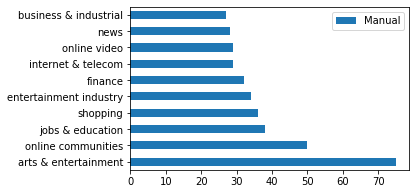

In [46]:
category_mismatch_plot(combined_mismatch, (5,3), 10)

### Which are mismatches ONLY?

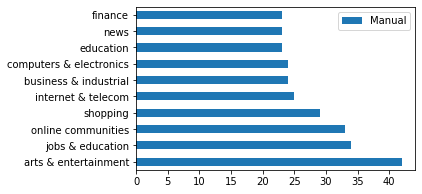

In [47]:
category_mismatch_plot(combined_mismatch_non_empty, (5,3), 10)

### Which are empty?

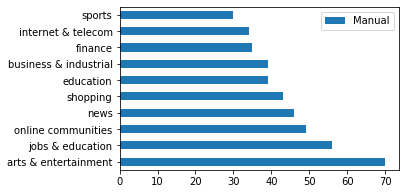

In [52]:
category_mismatch_plot(combined_empty, (5,3), 10)

#### But arts & entertainment is the most prominent label anyway. Look at the percentage of total labels

In [83]:
def category_mismatch_perc_plot(df, full_count_df, figsize, count):
    '''
    Given a filtered and unfiltered dataframe with labels, plot a bar plot of the percentage of that label that was mismatched
    Filter out the ones that have less than 10 occurrances 
    '''
    all_labels = full_count_df["Manual"].explode().value_counts()
    mismatch_labels = df["Manual"].explode().value_counts()
    
    to_plot = pd.DataFrame(labels/all_labels * 100).sort_values("Manual",ascending=False)
    to_plot.head(count).plot(kind="barh",figsize=figsize)

In [84]:
combined_mismatch["Manual"].explode().value_counts().sort_index()

academic conferences & publications     2
accounting & auditing                   3
acting & theater                       17
action & adventure films                1
action & platform games                 1
                                       ..
web apps & online tools                22
web design & development                3
web hosting                             1
women's clothing                        6
world news                              3
Name: Manual, Length: 176, dtype: int64

In [85]:
combined_df["Manual"].explode().value_counts().sort_index()

academic conferences & publications     3
accounting & auditing                   4
acting & theater                       19
action & adventure films                4
action & platform games                 3
                                       ..
web design & development                3
web hosting                             1
women's clothing                        9
world news                              5
wrestling                               1
Name: Manual, Length: 204, dtype: int64

### Which are mismatches OR empty?

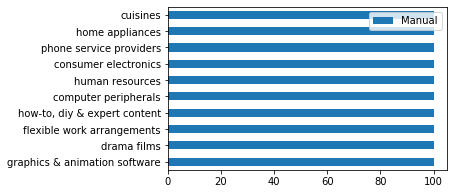

In [86]:
category_mismatch_perc_plot(combined_mismatch, combined_df, (5,3), 10)

### Which are mismatches ONLY?

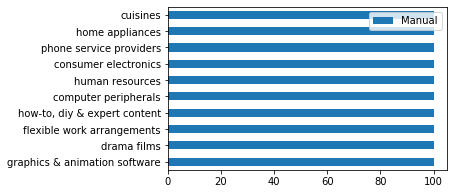

In [87]:
category_mismatch_perc_plot(combined_mismatch_non_empty, combined_df,(5,3), 10)

### Which are empty?

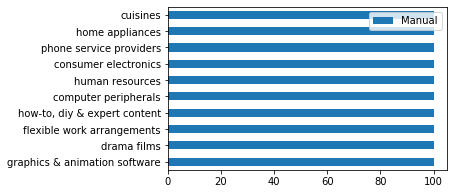

In [71]:
category_mismatch_perc_plot(combined_empty, combined_df,(5,3), 10)